In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(523)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import gridspec

import seaborn as sns
sns.set_style("ticks")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]
colors = sns.xkcd_palette(color_names)

from ssm import HMM
from ssm.util import find_permutation, one_hot

In [2]:
# Setup and simulate from a Poisson HMM

T = 2000   # number of time bins
D = 25     # number of observed neurons
K = 5      # number of states

# Make an LDS with somewhat interesting dynamics parameters
true_hmm = HMM(K, D, observations="poisson") 
P = np.eye(K) + 0.2 * np.diag(np.ones(K-1), k=1) + 1e-5 * np.ones((K,K))
P[-1,0] = 0.2
true_hmm.transitions.log_Ps = np.log(P)

log_lambdas = np.log(0.01 * np.ones((K, D)))
for k in range(K):
    log_lambdas[k,k*K:(k+1)*K] = np.log(0.2)
true_hmm.observations.log_lambdas = log_lambdas

z, y = true_hmm.sample(T)
z_test, y_test = true_hmm.sample(T)

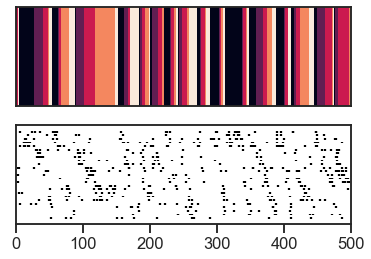

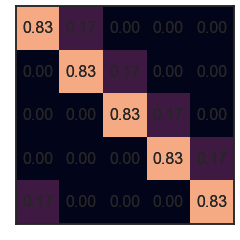

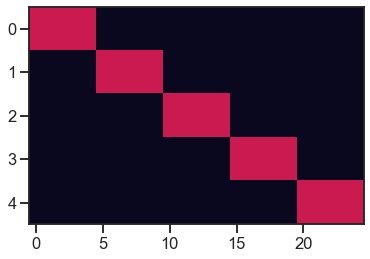

In [3]:
# visualize
T_plot=500
plt.figure()
plt.subplot(211)
plt.imshow(z[None,:], aspect="auto")
plt.xlim([0,T_plot])
plt.xticks([])
plt.yticks([])
plt.subplot(212)
# plt.plot(y)
for n in range(D):
    plt.eventplot(np.where(y[:,n]>0)[0]+1, linelengths=0.5, lineoffsets=D-n,color='k')
plt.xlim([0,T_plot])
plt.yticks([])

def plot_transition_matrix(transition_matrix, fontsize=16):
    plt.imshow(transition_matrix, vmin=0.0, vmax=1.0, aspect="auto")
    for (j,i),label in np.ndenumerate(transition_matrix):
        plt.text(i,j,'%.2f' % label,ha='center',va='center', fontsize=fontsize)
        plt.text(i,j,'%.2f' % label,ha='center',va='center', fontsize=fontsize)
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect("equal")

plt.figure()
plot_transition_matrix(true_hmm.transitions.transition_matrix)

def plot_log_lambdas(model):
    plt.imshow(np.exp(model.observations.log_lambdas), vmin=0.0, vmax=0.4, aspect="auto")

plt.figure()
plot_log_lambdas(true_hmm)

(0, 500)

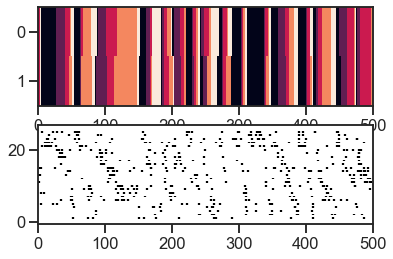

In [4]:
# Fit 10 Poisson HMMs to the data and keep the best one
N = 10
max_ll = -np.inf
for n in range(N):
    test_hmm_temp = HMM(K, D, observations="poisson") 
    poiss_lls_temp = test_hmm_temp.fit(y, num_iters=50)
    if poiss_lls_temp[-1] > max_ll:
        max_ll = poiss_lls_temp[-1]
        poiss_lls = poiss_lls_temp 
        test_hmm = test_hmm_temp
# test_hmm = HMM(K, D, observations="poisson") 
# poiss_lls = test_hmm.fit(y, num_iters=20)
test_hmm.permute(find_permutation(z, test_hmm.most_likely_states(y)))
smoothed_z = test_hmm.most_likely_states(y)

plt.figure()
plt.subplot(211)
plt.imshow(np.row_stack((z, smoothed_z)), aspect="auto")
plt.xlim([0,T_plot])
plt.subplot(212)
# plt.plot(y)
for n in range(D):
    plt.eventplot(np.where(y[:,n]>0)[0]+1, linelengths=0.5, lineoffsets=D-n,color='k')
plt.xlim([0,T_plot])


[1.16256064 0.96465973 0.81071993 1.05412537 1.15212542 1.09439524
 0.87026368 0.91717703 1.04453683 1.2078892  0.980912   0.79519973
 1.05765995 1.02066786 1.0490409  0.93920621 0.62320077 0.94635804
 1.03828107 1.03331169 1.36506988 1.02225045 0.86148833 1.15687795
 0.80774667]


[]

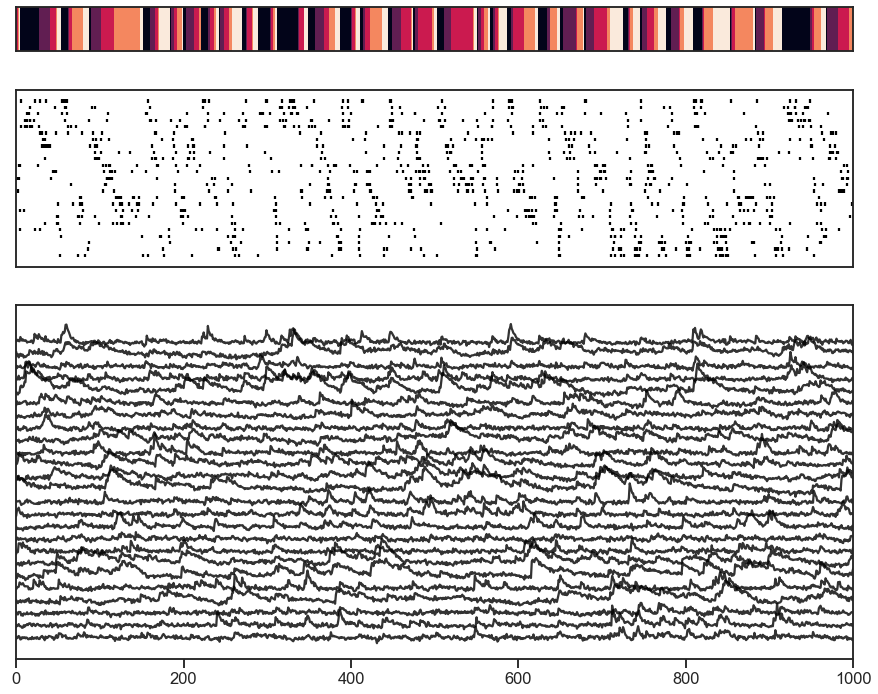

In [5]:
# Setup Calcium observations and simulate from them
As = np.clip(0.85 + 0.1 * npr.randn(D), 0.8, 0.95)
# betas = 1.0 * np.ones(D)
betas = 1.0 * np.ones(D) + 0.2 * npr.randn(D)
print(betas)
inv_etas = np.log(1e-2 * np.ones(D))
etas = np.exp(inv_etas)
mus = np.zeros_like(y) # start with zero mean
mus_test = np.zeros_like(y_test) 
y_ca = np.zeros((T, D))
y_ca_test = np.zeros((T, D))
y_ca[0] = mus[0, :] + np.sqrt(etas) * npr.randn(D) + betas * y[0, :]
y_ca_test[0] = mus[0, :] + np.sqrt(etas) * npr.randn(D) + betas * y_test[0, :]
for t in range(1, T):
    y_ca[t] = mus[t, :] + As * y_ca[t-1] + betas * y[t, :] + np.sqrt(etas) * npr.randn(D)
    y_ca_test[t] = mus_test[t, :] + As * y_ca_test[t-1] + betas * y_test[t, :] + np.sqrt(etas) * npr.randn(D)

# add per time point noise afterwards (not part of Ganmor generative model)
y_ca = y_ca + 0.2 * npr.randn(*y_ca.shape)
y_ca_test = y_ca_test + 0.2 * npr.randn(*y_ca_test.shape)

# T_plot
T_plot=1000
plt.figure(figsize=[15,12])
gs = gridspec.GridSpec(3, 1, height_ratios=[0.5, 2, 4]) 
a0 = plt.subplot(gs[0])
a1 = plt.subplot(gs[1])
a2 = plt.subplot(gs[2])
a0.imshow(z[None,:], aspect="auto")
a0.set_xlim([0,T_plot])
a0.set_xticks([])
a0.set_yticks([])
# plt.plot(y)
for n in range(D):
    a1.eventplot(np.where(y[:,n]>0)[0]+1, linelengths=0.5, lineoffsets=D-n,color='k')
a1.set_xlim([0,T_plot])
a1.set_xticks([])
a1.set_yticks([])
for n in range(D):
    a2.plot(y_ca[:, n] + 2.5 * (D-n), '-k', alpha=0.8)
    # plt.plot(y_ca_test2[:, n] + 2.5 * (D-n), '-g', alpha=0.8)
# y_dff = (y_ca - np.min(y_ca,axis=0)) / np.max(y_ca, axis=0)
# plt.imshow( y_dff.T, aspect="auto")
a2.set_xlim([0,T_plot])
a2.set_yticks([])

In [6]:
# Fit a Gaussian HMM to the calcium observations
N = 10
max_ll = -np.inf
for n in range(N):
    test_hmm_temp = HMM(K, D, observations="gaussian") 
    gauss_lls_temp = test_hmm_temp.fit(y_ca, num_iters=50)
    if gauss_lls_temp[-1] > max_ll:
        max_ll = gauss_lls_temp[-1]
        gauss_lls = gauss_lls_temp 
        test_hmm_gauss = test_hmm_temp
# test_hmm_gauss = HMM(K, D, observations="gaussian") 
# gauss_lls = test_hmm_gauss.fit(y_ca, num_iters=20)
test_hmm_gauss.permute(find_permutation(z, test_hmm_gauss.most_likely_states(y_ca)))
smoothed_z_gauss = test_hmm_gauss.most_likely_states(y_ca)
smoothed_y_gauss = test_hmm_gauss.smooth(y_ca)

In [7]:
# Fit an AR-HMM to the calcium observations
N = 10
max_ll = -np.inf
for n in range(N):
    test_hmm_temp = HMM(K, D, observations="diagonal_ar") 
    ar_lls_temp = test_hmm_temp.fit(y_ca, num_iters=50)
    if ar_lls_temp[-1] > max_ll:
        max_ll = ar_lls_temp[-1]
        ar_lls = ar_lls_temp 
        test_hmm_ar = test_hmm_temp
test_hmm_ar.permute(find_permutation(z, test_hmm_ar.most_likely_states(y_ca)))
smoothed_z_ar = test_hmm_ar.most_likely_states(y_ca)
smoothed_y_ar = test_hmm_ar.smooth(y_ca)

In [8]:
# try initializaing Calcium HMM via GLM with constant firing rate. 
from autograd import grad
from autograd.scipy.special import gammaln, logsumexp 
from autograd.misc import flatten
from scipy.optimize import minimize

def softplus_stable(x, bias=None, dt=1.0):

    if bias is not None:
        inp = x+bias 

    f = np.log1p(np.exp(inp)) * dt 
    logf = np.log(f) 
    df = np.exp(inp) / (1.0 + np.exp(inp)) * dt
    ddf = np.exp(inp) / (1.0 + np.exp(inp))**2 * dt

    return f, logf, df, ddf

def exp_stable(x, dt=1.0):

    f = np.exp(x) * dt
    logf = x + np.log(dt)
    df = f
    ddf = f

    return f, logf, df, ddf

def nll_GLM_GanmorCalciumAR1(w, X, Y, hyperparams, nlfun, S=10):
    """
    Negative log-likelihood for a GLM with Ganmor AR1 mixture model for calcium imaging data.

    Input:
        w:              [D x 1]  vector of GLM regression weights
        X:              [T x D]  design matrix
        Y:              [T x 1]  calcium fluorescence observations
        hyperparams:    [3 x 1]  model hyperparameters: log tau, log alpha, log Gaussian variance
        nlfun:          [func]   function handle for nonlinearity
        S:              [scalar] number of spikes to marginalize
        return_hess:    [bool]   flag for returning Hessian

    Output:
        negative log-likelihood, gradient, and Hessian
    """

    # unpack hyperparams
    tau, alpha, sig2 = np.exp(hyperparams)

    # compute AR(1) diffs
    taudecay = np.exp(-1.0/tau) # decay factor for one time bin
    Y = np.pad(Y, (1,0)) # pad Y by a time bin
    Ydff = (Y[1:] - taudecay * Y[:-1]) / alpha

    # compute grid of spike counts
    ygrid = np.arange(0, S+1)

    # Gaussian log-likelihood terms
    log_gauss_grid = - 0.5 * (Ydff[:,None]-ygrid[None,:])**2 / (sig2 / alpha**2) - 0.5 * np.log(2.0 * np.pi * sig2)
    
    Xproj = X@w
    poissConst = gammaln(ygrid+1)

    # compute neglogli, gradient, and (optionally) Hessian
    f, logf, df, ddf = nlfun(Xproj)
    logPcounts = logf[:,None] * ygrid[None,:] - f[:,None] - poissConst[None,:]

    # compute log-likelihood for each time bin
    logjoint = log_gauss_grid + logPcounts 
    logli = logsumexp(logjoint, axis=1) # log likelihood for each time bin
    negL = -np.sum(logli) # negative log likelihood

    return negL

def initialize_neuron(Yobs):

    Xmat = np.ones((len(Yobs),1))
    nlfun = lambda x : exp_stable(x, dt=1.0)
    # compute nll
    def _obj(_params):
        w = _params[0]
        hyperparams = _params[1]
        return nll_GLM_GanmorCalciumAR1(w, Xmat, Yobs, hyperparams, nlfun)

    hyperparams_init = [np.log(1.0), np.log(1.0), np.log(0.1)] # assume low noise, for now
    w_init = np.array([1.0])
    _params = [w_init, hyperparams_init]

    params, unflatten = flatten(_params)
    obj = lambda params : _obj(unflatten(params))
    grad_func = grad(obj)

    params_init = np.concatenate((w_init, hyperparams_init))
    res = minimize(obj, x0=params_init, jac=grad_func)
    params_mle = res.x

    _params_mle = unflatten(params_mle)
    w_mle = _params_mle[0]
    tau_mle, beta_mle, var_mle = np.exp(_params_mle[1])
    
    A_mle = np.exp(-1.0 / tau_mle)
    
    return w_mle, A_mle, beta_mle, var_mle

In [9]:
# initialize
test_hmm_ca = HMM(K, D, observations="calcium") 
test_As = np.zeros_like(As)
test_betas = np.zeros_like(betas)
test_etas = np.zeros_like(etas)
for d in range(D):
    _, A_mle, beta_mle, var_mle = initialize_neuron(y_ca[:,d])
    test_As[d] = A_mle
    test_betas[d] = beta_mle
    test_etas[d] = var_mle

/Users/dz5/opt/anaconda3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: divide by zero encountered in true_divide
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/Users/dz5/opt/anaconda3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: invalid value encountered in true_divide
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/Users/dz5/opt/anaconda3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in double_scalars
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/Users/dz5/opt/anaconda3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: invalid value encountered in double_scalars
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


In [13]:
np.var(y_ca,axis=0)

array([0.37186837, 1.10074561, 0.18290669, 0.3985651 , 1.56582912,
       0.37044526, 0.36071299, 0.2218888 , 0.63749241, 0.32733586,
       0.75200695, 0.53410148, 1.35424341, 0.30708924, 0.27517775,
       0.32718452, 0.12266051, 0.24440067, 0.74604726, 0.67670789,
       0.54875247, 0.97631158, 0.27556156, 0.3076316 , 0.17187098])

Text(0.5, 1.0, 'betas')

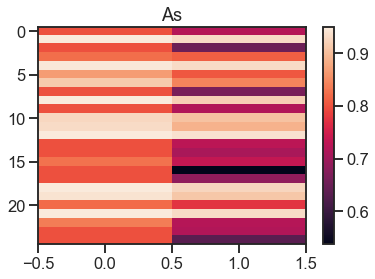

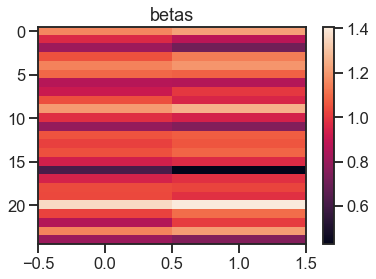

In [10]:
plt.figure()
As_plot = np.hstack((As[:,None], test_As[:,None]))
plt.imshow(As_plot, aspect="auto")
plt.colorbar()
plt.title("As")

plt.figure()
betas_plot = np.hstack((betas[:,None], test_betas[:,None]))
plt.imshow(betas_plot, aspect="auto")
plt.colorbar()
plt.title("betas")


In [10]:
# initialize 
# test_hmm_ca = HMM(K, D, observations="calcium") 
# test_As = np.zeros_like(As)
# test_etas = np.zeros_like(etas)
# for d in range(D):
#     yd = y_ca[:,d]
#     test_As[d] = 1.0 / np.sum(yd[:-1] **2 ) * np.dot(yd[:-1], yd[1:]) * 1.0 # deflate because not taking into account spikes
#     sqerr = np.sum( ( yd[1:] - test_As[d] * yd[:-1] )**2 ) / (T-1)
#     test_etas[d] = sqerr 

In [11]:
# print(test_As[1])
# print(test_etas[1])

In [14]:
# fit a calcium hmm
# inv_betas = np.log(1.0 * np.ones(D) + 0.2 * npr.randn(D))
inv_betas = np.log(test_betas)
inv_etas = np.log(test_etas)
inv_As = np.log(test_As)
test_hmm_ca.observations.params = \
    (test_hmm_ca.observations.log_lambdas, inv_As, inv_betas, inv_etas)

# potentially start with SGD optimization
ca_lls0 = test_hmm_ca.fit(y_ca, num_iters=1000, method="sgd") 

# before optimizing with EM
ca_lls = test_hmm_ca.fit(y_ca, num_iters=20, observations_mstep_kwargs={"num_iters":100})

test_hmm_ca.permute(find_permutation(z, test_hmm_ca.most_likely_states(y_ca)))
smoothed_z_ca = test_hmm_ca.most_likely_states(y_ca)
smoothed_y_ca = test_hmm_ca.smooth(y_ca)

/Users/dz5/github/ssm/ssm/optimizers.py:132: UserWarning: L-BFGS-B failed with message:
b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  warn("{} failed with message:\n{}".format(method, result.message))


In [13]:
# ca_lls2 = test_hmm_ca.fit(y_ca, num_iters=20, observations_mstep_kwargs={"num_iters":100})
# test_hmm_ca.permute(find_permutation(z, test_hmm_ca.most_likely_states(y_ca)))
# smoothed_z_ca = test_hmm_ca.most_likely_states(y_ca)
# smoothed_y_ca = test_hmm_ca.smooth(y_ca)

(0, 1000)

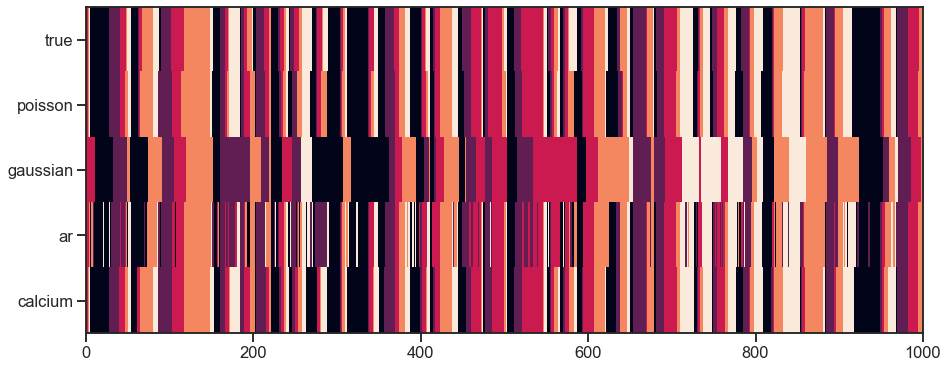

In [15]:
plt.figure(figsize=[15,6])
plt.imshow(np.row_stack((z, smoothed_z, smoothed_z_gauss, smoothed_z_ar, smoothed_z_ca)), aspect="auto")
plt.yticks([0,1,2,3,4],["true","poisson","gaussian","ar","calcium"])
plt.ylim([4.5,-0.5])
plt.xlim([0, T_plot])

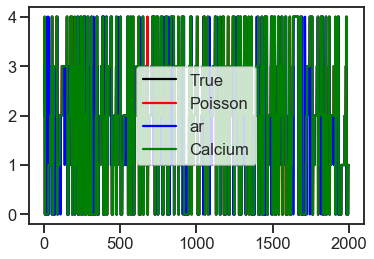

In [16]:
plt.figure()
plt.plot(z, 'k', label="True")
plt.plot(smoothed_z, 'r', label="Poisson")
# plt.plot(smoothed_z_gauss, 'b', label="Gaussian")
plt.plot(smoothed_z_ar, 'b', label="ar")
plt.plot(smoothed_z_ca, 'g', label="Calcium")
plt.legend()

In [17]:
# test data
# y_ca_test = y_ca_test + 0.2 * npr.randn(*y_ca_test.shape)
poiss_test_ll = test_hmm.log_likelihood(y_test)
ca_test_ll = test_hmm_ca.log_likelihood(y_ca_test)
gauss_test_ll = test_hmm_gauss.log_likelihood(y_ca_test)
ar_test_ll = test_hmm_ar.log_likelihood(y_ca_test)

smoothed_z_test = test_hmm.most_likely_states(y_test)
smoothed_z_ca_test = test_hmm_ca.most_likely_states(y_ca_test)
smoothed_z_gauss_test = test_hmm_gauss.most_likely_states(y_ca_test)
smoothed_z_gauss_ar_test = test_hmm_ar.most_likely_states(y_ca_test)

Test log likelihoods
Gaussian:  -46879.70948955655
AR:  -18823.32916725202
Calcium:  -13529.576296067948


Text(0.5, 1.0, 'Most Likely Discrete States on Test Data')

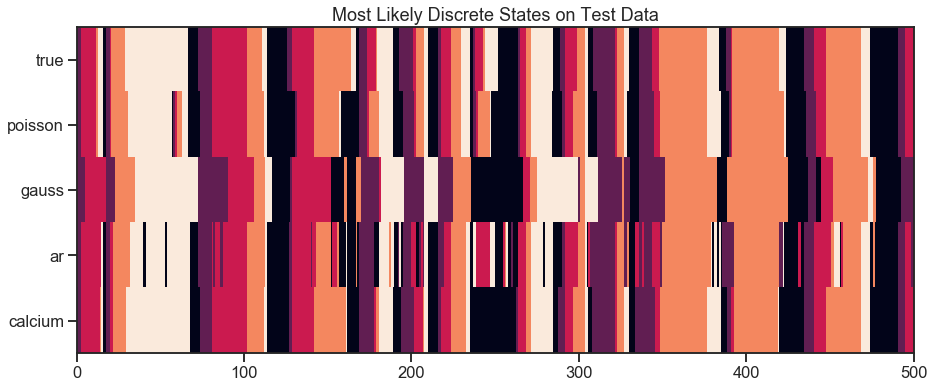

In [18]:
print("Test log likelihoods")
print("Gaussian: ", gauss_test_ll)
print("AR: ", ar_test_ll)
print("Calcium: ", ca_test_ll)

plt.figure(figsize=[15,6])
plt.imshow(np.row_stack((z_test, smoothed_z_test, smoothed_z_gauss_test, smoothed_z_gauss_ar_test, smoothed_z_ca_test)), aspect="auto")
plt.xlim([0, 500])
plt.yticks([0,1,2,3,4],["true","poisson","gauss","ar","calcium"])
plt.ylim([4.5,-0.5])
plt.title("Most Likely Discrete States on Test Data")

(200, 300)

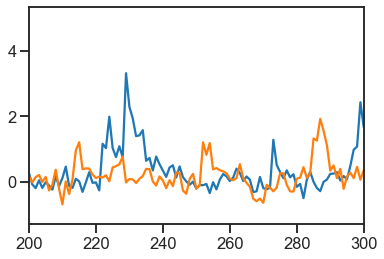

In [19]:
# plt.figure(figsize=[15,10])
# for n in range(D):
#     plt.plot(y_ca[:, n] + 3 * (D-n), '-k', label="True" if n == 0 else None)
#     plt.plot(smoothed_y_gauss[:, n] + 3 * (D-n), '-b', label="Gaussian" if n == 0 else None)
#     plt.plot(smoothed_y_ca[:, n] + 3 * (D-n), '-g', label="Calcium" if n == 0 else None)
# plt.xlim([0, 100])
plt.figure()
plt.plot(y_ca[:,0])
plt.plot(y_ca_test[:,0])
plt.xlim([200,300])

(0, 100)

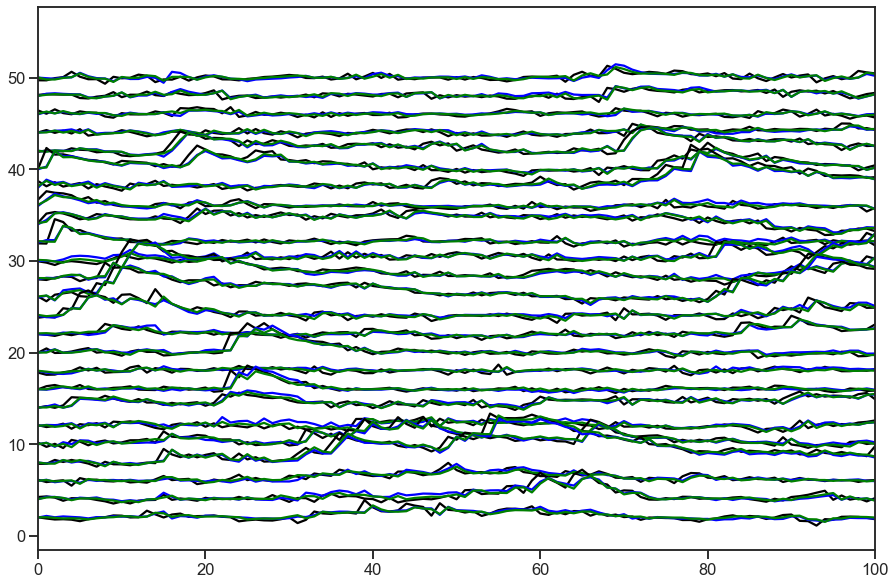

In [22]:
smoothed_y_ca_test_gauss = test_hmm_gauss.smooth(y_ca_test)
smoothed_y_ca_test_ar = test_hmm_ar.smooth(y_ca_test)
smoothed_y_ca_test_ca = test_hmm_ca.smooth(y_ca_test)

plt.figure(figsize=[15,10])
for n in range(D):
    plt.plot(y_ca_test[:, n] + 2 * (D-n), '-k', label="True" if n == 0 else None)
    plt.plot(smoothed_y_ca_test_ar[:, n] + 2 * (D-n), '-b', label="AR" if n == 0 else None)
    plt.plot(smoothed_y_ca_test_ca[:, n] + 2 * (D-n), '-g', label="Calcium" if n == 0 else None)
plt.xlim([0, 100])

Text(0.5, 1.0, 'ganmor')

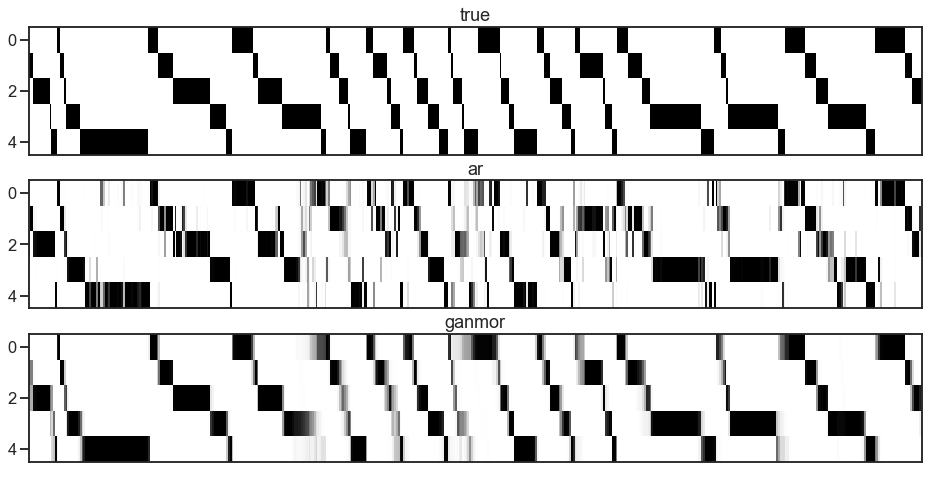

In [23]:
# posterior expectations
# poiss_expectations = test_hmm.expected_states(y)[0]
ar_expectations = test_hmm_ar.expected_states(y_ca_test)[0]
ganmor_expectations = test_hmm_ca.expected_states(y_ca_test)[0]

T_plot = 500
plt.figure(figsize=[16,8])
plt.subplot(311)
plt.imshow(one_hot(z_test, K=K).T, aspect="auto", vmin=0.0, vmax=1.0, cmap="Greys")
plt.title("true")
plt.xlim([0, T_plot])
plt.xticks([])
plt.subplot(312)
plt.imshow(ar_expectations.T, aspect="auto", vmin=0.0, vmax=1.0, cmap="Greys")
plt.xlim([0, T_plot])
plt.xticks([])
plt.title("ar")
plt.subplot(313)
plt.imshow(ganmor_expectations.T, aspect="auto", vmin=0.0, vmax=1.0, cmap="Greys")
plt.xlim([0, T_plot])
plt.xticks([])
plt.title("ganmor")

<Figure size 432x288 with 0 Axes>

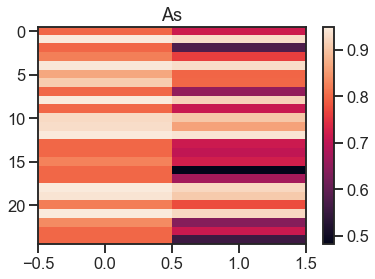

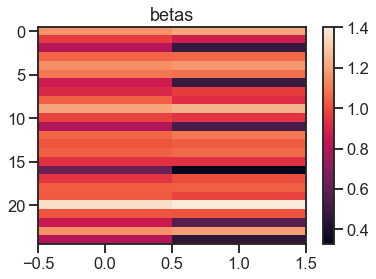

<Figure size 432x288 with 0 Axes>

In [24]:
plt.figure()
As_plot = np.hstack((As[:,None], np.exp(test_hmm_ca.observations.inv_As)[:,None]))
plt.imshow(As_plot, aspect="auto")
plt.colorbar()
plt.title("As")

plt.figure()
betas_plot = np.hstack((betas[:,None], np.exp(test_hmm_ca.observations.inv_betas)[:,None]))
plt.imshow(betas_plot, aspect="auto")
plt.colorbar()
plt.title("betas")

plt.figure()


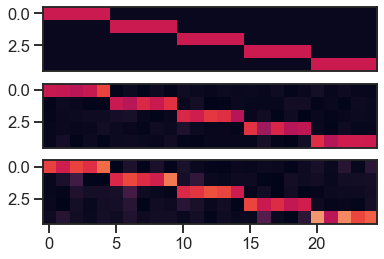

In [29]:
def plot_log_lambdas(model):
    plt.imshow(np.exp(model.observations.log_lambdas), vmin=0.0, vmax=0.4, aspect="auto")

plt.figure()
plt.subplot(311)
plot_log_lambdas(true_hmm)
plt.xticks([])
plt.subplot(312)
plot_log_lambdas(test_hmm)
plt.xticks([])
plt.subplot(313)
# plot_log_lambdas(test_hmm_ca)
scaled_lambdas = test_hmm_ca.observations.log_lambdas + test_hmm_ca.observations.inv_betas[None,:]
plt.imshow(np.exp(scaled_lambdas), vmin=0.0, vmax=0.4, aspect="auto")

In [28]:
(test_hmm_ca.observations.log_lambdas + test_hmm_ca.observations.inv_betas[None,:]).shape

(5, 25)

(0, 250)

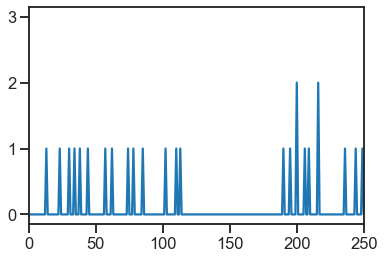

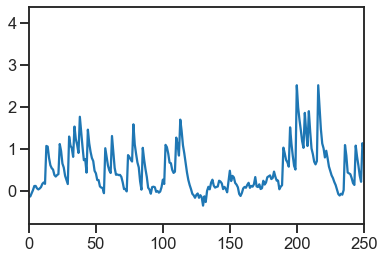

In [23]:
# investigate log likelihood
rate = 10 # spikes per second
bin_size = 0.01 # time bin in seconds
T = 20000 # time length, number of bins

# generate spike counts
Ysps = npr.poisson(rate * bin_size, (T,))

# generate Ca traces
a_true = 0.8
beta_true = 1.0
sig2_true = 0.01

Yobs = np.zeros(T)
Yobs[0] = beta_true * Ysps[0] +  np.sqrt(sig2_true) * npr.randn()
for t in range(1,T):
    Yobs[t] = beta_true * Ysps[t] + a_true * Yobs[t-1] + np.sqrt(sig2_true) * npr.randn()


plt.figure()
plt.plot(Ysps)
plt.xlim([0,250])
plt.figure()
plt.plot(Yobs)
plt.xlim([0,250])


In [24]:
tau = 1.0 / np.log(1.0 / a_true)
print(tau)
print(a_true)
print(np.exp(-1.0 / tau))

4.481420117724549
0.8
0.7999999999999999


In [25]:
nlfun = lambda x : exp_stable(x, dt=bin_size)
log_rate = np.log(rate * bin_size)
tau = 1.0 / np.log(1.0 / a_true)

X = np.ones((T, 1))
# w = log_rate

rates = np.arange(5,16,1)
betas = np.arange(0.5,1.6,0.1)

nr = len(rates)
nb = len(betas)
nlls = np.zeros((nr,nb))

r_vals, b_vals = np.meshgrid(rates, betas)
for i in range(nr):
    for j in range(nb):
        w = np.array([np.log(rates[i])])
        beta = betas[j]
        hyperparams = [np.log(tau), np.log(beta), np.log(sig2_true)]
        nlls[i,j] = nll_GLM_GanmorCalciumAR1(w, X, Yobs, hyperparams, nlfun, S=10)
        print("Rate: ", rates[i], " Beta: ", betas[j], " NLL: ", nlls[i,j])



Rate:  5  Beta:  0.5  NLL:  -3068.036751452305
Rate:  5  Beta:  0.6  NLL:  -2143.224126150809
Rate:  5  Beta:  0.7  NLL:  -2858.1727751343547
Rate:  5  Beta:  0.7999999999999999  NLL:  -6199.539453034726
Rate:  5  Beta:  0.8999999999999999  NLL:  -9386.222862213119
Rate:  5  Beta:  0.9999999999999999  NLL:  -10530.04556360481
Rate:  5  Beta:  1.0999999999999999  NLL:  -9413.925822679968
Rate:  5  Beta:  1.1999999999999997  NLL:  -6073.772244733905
Rate:  5  Beta:  1.2999999999999998  NLL:  -822.8534655603181
Rate:  5  Beta:  1.4  NLL:  5656.886633375212
Rate:  5  Beta:  1.4999999999999998  NLL:  13509.242648887655
Rate:  6  Beta:  0.5  NLL:  -3609.9473918224307
Rate:  6  Beta:  0.6  NLL:  -2555.8780137380977
Rate:  6  Beta:  0.7  NLL:  -3106.1721605301354
Rate:  6  Beta:  0.7999999999999999  NLL:  -6383.583150339358
Rate:  6  Beta:  0.8999999999999999  NLL:  -9561.45033879117
Rate:  6  Beta:  0.9999999999999999  NLL:  -10705.26333246369
Rate:  6  Beta:  1.0999999999999999  NLL:  -9589.

(5, 5)
10
0.9999999999999999


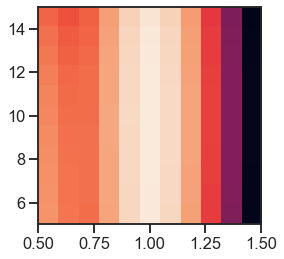

In [26]:
fig = plt.figure(figsize=[4,4])
ax = plt.gca()
im = ax.imshow(-1.0 * nlls, extent=(betas[0], betas[-1], rates[0], rates[-1]), aspect="auto")
# ax.set_xticks(rates, extent=(rates[0], rates[-1], betas[0], betas[-1]))

# plt.imshow(nlls)
# Loop over data dimensions and create text annotations.
# for i in range(nr):
#     for j in range(nb):
#         text = ax.text(rates[j], betas[i], "{:4.1f}".format(-1.0 * nlls[i, j]),
#                        ha="center", va="center", color="k")

index = np.unravel_index(np.argmax(-1.0 * nlls), nlls.shape)
print(index)
print(rates[index[0]])
print(betas[index[1]])

In [27]:
print(nlls[:,5] * -1.0)

[10530.0455636  10705.26333246 10822.50543699 10897.31304873
 10939.71054203 10956.54248931 10952.6908455  10931.76026557
 10896.48816424 10849.00237726 10790.98971314]
